# Decoding Hits: Predicting Song Popularity with Spotify Data

In the realm of music and data science, I recently delved into the expansive world of Spotify's dataset. My aim was to investigate the correlation between various musical attributes and the elusive concept of song popularity. Using machine learning, specifically through linear regression models, I sought to unveil the nuanced patterns influencing a song's success.

This blog post invites you to join me on a pragmatic exploration of Spotify's data landscape. As we analyze variables like danceability, energy, key, and tempo, our goal is to uncover potential predictors shaping a song's popularity. Beyond the algorithms, this journey delves into the genuine connection between data science and the expressive artistry of music.

Together, we'll navigate the diverse terrain of Spotify data, seeking to understand the multifaceted factors that contribute to a song's impact on its audience. This exploration is rooted in the precision of machine learning but driven by a genuine curiosity for the dynamics that make music resonate. Let's embark on this data-driven exploration, where the rhythms of data meet the intricacies of musical expression.




## 1. Dataset and Variables

I downloaded my dataset from kaggle. I looked for Spotify data that included many different types of features as well as a dataset with many observations so that we can see a bit better how our model is doing with predictions. I chose the set called "[30000 Spotify Songs](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)".

This data set includes many variables of which include:

Character:

- track_id
- track_name
- track_artist
- track_album_id
- track_album_name
- track_album_release_date
- playlist_name
- playlist_id
- playlist_genre
- playlist_subgenre

Double:

- track_popularity
- danceability
- energy
- key (categorical)
- loudness
- mode (categorical)
- speechiness
- acousticness
- instrumentalness
- liveness
- tempo
- duration_ms

\* For more details about specific features, please visit the site linked above to Kaggle.

#### 1.1 Exploratory Data Analysis

After extensive EDA, it doesn't appear as though there is any obvious multicollinearity. Potentially there could be some between energy and loudness, but it doesn't seem like there is much to worry about with that.


Note that most of our data comes from around 2015-2020 which makes sense since Spotify really gained popularity around then. This makes our data classes a bit unbalanced, so we will need to take that into account when looking at the performance of our model.

Instrumentalness, liveness, acousticness, and speechiness are all right skewed.

Tempo, duration, valence, and popularity are all symmetrical.

Loudness, danceability, and energy are all left skewed.

## 2. Data Preprocessing

The data preprocessing process included dropping 5 rows that contained missing values that could not be imputed as they were strings, converting variables to the correct types, and selecting which variables to use for analysis (since linear regression doesn't handle string values well). The code used for all of these steps is shown below.

In [1]:
# packages used:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge


# Read in data
dfsongs = pd.read_csv('https://github.com/britt-anderson/Data/raw/main/spotify_songs.csv')

# Cleaning dfsongs

# Convert 'track_album_release_date' to datetime format
dfsongs['track_album_release_date'] = pd.to_datetime(dfsongs['track_album_release_date'])

# Extract the year from the date
dfsongs['year'] = dfsongs['track_album_release_date'].dt.year

# drop columns that don't add necessary information for our analysis
songs = dfsongs.drop(columns=['track_id', 'playlist_id', 'track_artist', 'track_album_id', 'track_album_name', 'track_album_release_date'])


# Drop the 5 missing values out of over 32,000

dfsongs = dfsongs.dropna()

# Specify columns to convert to factors
factor_columns = ['playlist_name', 'playlist_genre', 'playlist_subgenre', 'key', 'mode']

# Convert specified columns to the categorical data type
songs[factor_columns] = songs[factor_columns].astype('category')

# Convert 'year' to datetime without adding days
songs['year'] = pd.to_datetime(songs['year'].astype(str), format='%Y')


I then proceeded to separated my data into a test and train set.

In [2]:
# Separate features and target variable
X = songs[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence',
           'tempo', 'duration_ms']]

y = songs['track_popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


The data is now ready to be used in model building.

## 3. Model Building

#### 3.1 Simple Linear Regression

I first decided to us a simple linear regression model just to have a baseline to compare my other analyses to. Included below is the code used for that analysis.

In [3]:
# Initialize and train the Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = regressor.predict(X_test)

In [4]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared (R2) value
r2_value = r2_score(y_test, predictions)
print(f'R2 Score: {r2_value}')

Mean Squared Error: 577.0209166605165
R2 Score: 0.07071588877571289


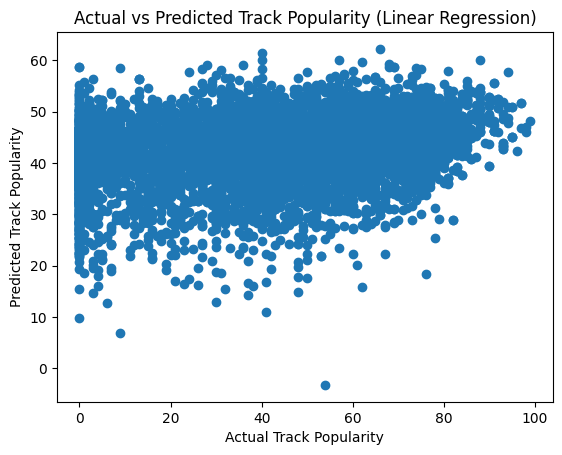

In [5]:
# Visualize predicted vs actual values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Track Popularity')
plt.ylabel('Predicted Track Popularity')
plt.title('Actual vs Predicted Track Popularity (Linear Regression)')
plt.show()

This analysis provided a MSE of 577.02 and an $R^2$ of 0.071. When you look at the graph as well, all of the predictions are pretty much between 20 and 60 which means our model didn't predict very many of the high and low ranking songs. This is probably a big cause for the MSE and $R^2$. This model performed very poorly and accounts for very little of the variability of our data. It does, however, give us a good starting point to compare the rest of our models to.

#### 3.2 Ridge Regression

In [6]:
# alpha values
alphas = np.arange(0.1, 1.1, 0.1)

# Create a dictionary with alpha values
param_grid = {'alpha': alphas}

# Initialize Ridge regression model
ridge = Ridge()

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Best alpha is evaluated to be 1.0

In [7]:
# build the ridge regression
ridge_regressor = Ridge(alpha=best_alpha)
ridge_regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

# Calculate R-squared (R2) value
r2_value = r2_score(y_test, predictions)
print(f'R2 Score: {r2_value}')

Mean Squared Error on Test Set: 577.0220906146685
R2 Score: 0.07071399813897972


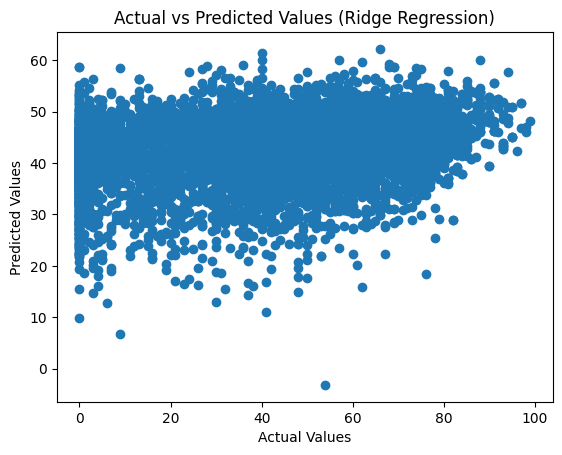

In [8]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Ridge Regression)')
plt.show()

This analysis has almost the exact same results as the simple linear model. The MSE is 577.02 and the $R^2$ is 0.071. The graph looks similar as well. This model would not be very effective in predicting song popularity.

#### 3.3 Random Forest Regressor

I used Cross Validation to perfrom a grid search to ensure the best model was used for my random forest.

In [10]:
# Define the hyperparameter grid
# uncomment the code below to run the grid search yourself
#param_grid = {
#    'n_estimators': [50, 100, 150],
#    'max_depth': [None, 10, 20],
#}
# best params: max_depth = None, n_estimators = 150)
param_grid = {
    'n_estimators': [150],
    'max_depth': [None],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [11]:
# Train the model with the best hyperparameters on the entire training set
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

# Calculate R-squared (R2) value
r2_value = r2_score(y_test, predictions)
print(f'R2 Score: {r2_value}')



Mean Squared Error on Test Set: 435.57393270053836
R2 Score: 0.2985142769785759


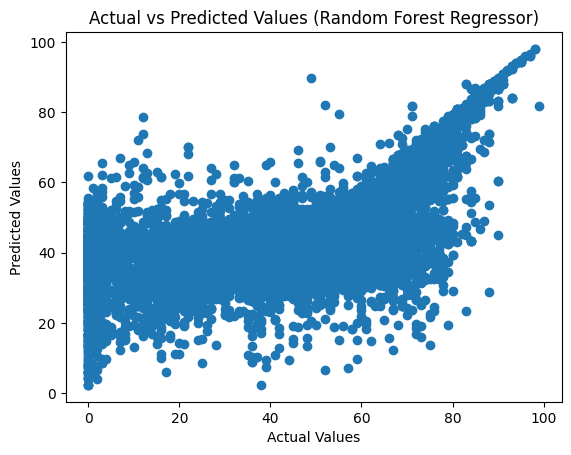

In [12]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest Regressor)')
plt.show()

This model has a significantly lower MSE at 447 (which is still high, but more than 100 lower than the other models) and an $R^2$ of 0.3. This graph seems to show that when the actual value is above 40, our model does a pretty good job predicting the value. When the actual value is much lower than that, it is not quite as accurate.

\*This code took much longer to run as well. Note that it took 4 minutes to run.

## 4. Results and Insights

The results of this test show that song features (like danceability, tempo, acousticness, etc.,) are not necessarily good predictors of a song's popularity. Each of my analyses accounted for less than a third of the variability of the data. This is not a great model, but we know that it is not because of our hyperparameters.

With the random forest regressor, I established that there was no max_depth and that the n_estimators would be 150. This allowed the random forest regressor to use a lot of computational energy to find a model that best fit the data. With this model, we still have a lackluster model.



## 5. Challenges and Limitations

The results of this analysis do make sense when thinking about song popularity in general. Popular songs take many different genres, tempos, keys, etc. In addition, since this included songs from many years ago, and Spotify is a newer platform to listen to music on, it seems like the misrepresentation of those songs in the past may lead to why our data has a more difficult time predicting less popular songs.

In addition, linear regression does not handle categorical or string data very well. If I was able to include some of the variables like artist or album name, I wonder if the model would be able to predict popularity better.


## 6. Conclusion and Future Questions

This analysis allowed me to see real life application of different types of linear regression. It cemented the idea that models that are given more space to fit a model and more flexibility often perform better (even with the increased chance of overfitting). Although none of the models performed well enough to make any decisions off of, the random forest regressor performed the best and if necessary, would be the chosen model for predicting song popularity.

This analysis prompts me to run further tests using songs just released during a certain time period, or finding ways to engineer my features to include explanatory variables like artist or album name.